# Predicting global temperature anomaly data

## I - Imports

In [2]:
import pandas as pd
import torch
import torch.nn as nn
import torchvision
import torch.optim as optim
import numpy as np
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

## II - Preparing the dataset

### II - a - Loading the dataset

In [3]:
df = pd.read_csv(r'.\data\Global_mean_nasa.csv', skiprows=1, header=0)

df = df[pd.to_numeric(df['Year'], errors='coerce').notna()]

df.replace('*******', np.nan, inplace=True)

months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
df_months = df[['Year'] + months].copy()

for col in df_months.columns:
    df_months[col] = df_months[col].astype(float)

print(df_months.isnull().sum())
print(df_months.columns)

Year    0
Jan     2
Feb     2
Mar     2
Apr     2
May     2
Jun     2
Jul     2
Aug     2
Sep     3
Oct     3
Nov     3
Dec     3
dtype: int64
Index(['Year', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep',
       'Oct', 'Nov', 'Dec'],
      dtype='object')


### II - b - Convert to single time series

In [4]:
df_long = df_months.melt(id_vars=['Year'], value_vars=months, 
                         var_name='Month', value_name='Temp')

df_long['Date'] = pd.to_datetime(df_long['Year'].astype(int).astype(str) + '-' + df_long['Month'], format='%Y-%b')

df_long = df_long.sort_values('Date')

data = df_long['Temp'].values


### II - c - Handling missing values and normalize

In [5]:
data = pd.Series(data).interpolate()
data = data.fillna(method='ffill')     
data = data.fillna(method='bfill') 
data = data.values

scaler = MinMaxScaler(feature_range=(0,1))
data_normalized = scaler.fit_transform(data.reshape(-1,1))

C:\Users\mateo\AppData\Local\Temp\ipykernel_20748\2108870625.py:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.fillna(method='ffill')
C:\Users\mateo\AppData\Local\Temp\ipykernel_20748\2108870625.py:3: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.fillna(method='bfill')


## III - Setup of the Dataset

### III - a - Creating a Dataset class

In [6]:
class TemperatureDataset(Dataset):
    def __init__(self, data, seq_length = 24):
        self.data = data
        self.seq_length = seq_length
    
    def __len__(self):
        return len(self.data) - self.seq_length
    
    def __getitem__(self, idx):
        x = self.data[idx : idx + self.seq_length]
        y = self.data[idx + self.seq_length]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

### III - Split between train and test 

In [7]:
train_size = int(len(data_normalized) * 0.8)
train_data = data_normalized[:train_size]

test_data = data_normalized[train_size:]

seq_length = 24

train_dataset = TemperatureDataset(train_data, seq_length)
test_dataset = TemperatureDataset(test_data, seq_length)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)



## IV - Building the GRU

In [8]:
class GRUModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=2, output_size=1):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        out, _ = self.gru(x)
        out = self.fc(out[:, -1, :])
        return out 

## V - Training the model

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = GRUModel().to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

n_epochs = 10

for epoch in range(n_epochs):
    running_loss = 0.0
    for x,y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        output = model(x)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    print(f'Epoch {epoch+1}/{n_epochs}, Loss: {running_loss/len(train_loader):.6f}')




Epoch 1/10, Loss: 0.081870
Epoch 2/10, Loss: 0.016267
Epoch 3/10, Loss: 0.012530
Epoch 4/10, Loss: 0.009843
Epoch 5/10, Loss: 0.007008
Epoch 6/10, Loss: 0.005433
Epoch 7/10, Loss: 0.005198
Epoch 8/10, Loss: 0.005174
Epoch 9/10, Loss: 0.004886
Epoch 10/10, Loss: 0.004962


## VI - Training the model

In [10]:
model.eval()
predictions = []
actuals = []

with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        y = y.to(device)
        output = model(x)
        predictions.append(output.cpu())
        actuals.append(y.cpu())

predictions = torch.cat(predictions).numpy()
actuals = torch.cat(actuals).numpy()

## VII - We plot

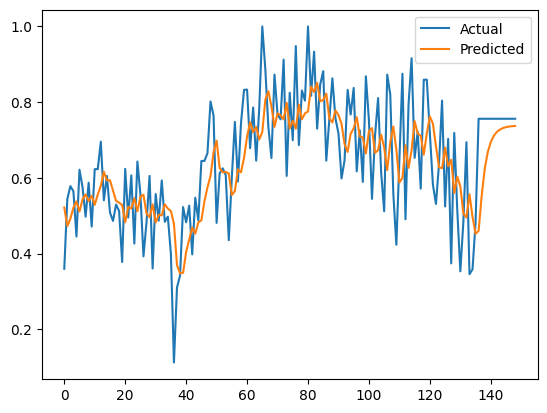

In [11]:
import matplotlib.pyplot as plt

plt.plot(actuals, label='Actual')
plt.plot(predictions, label='Predicted')
plt.legend()
plt.show()


## VIII - Computation of the Errors Metrics

In [12]:

mae = mean_absolute_error(actuals, predictions)
rmse = np.sqrt(mean_squared_error(actuals, predictions))
r2 = r2_score(actuals, predictions)

print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R2 Score: {r2:.4f}")


MAE: 0.1047
RMSE: 0.1280
R2 Score: 0.3697
